In [1]:
import torch
from torch.autograd import Variable
from torch.autograd import grad
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import functions1d as fun


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
which = 'p3b'
# options available: p0, p1, p2, p3, p3b

### Differential equation: 
example: $\frac{\partial x}{\partial t} = - \lambda x$

In [3]:
diff_eq = fun.diff_eq[which]
degree = fun.degree[which]

### Real function:
example: $x(t) = e^{-\lambda t}$

In [4]:
real = fun.function[which]

### Trial function:
example: $\hat{f(t)} = 1 + t * N(t)$

where N(t) is a neural network with 1 input and 1 output and an arbitrary number of hidden layers and neurons

In [5]:
trial = fun.trial[which]

Function needed to perform the training

In [6]:
def g(t, nn):
    x = trial(nn, t)
    gx = []
    gradx, = grad([x], [t], grad_outputs=torch.ones(t.shape), create_graph=True)
    gx.append(gradx)
    if degree > 1:
        grad2x, = grad([gradx], [t], grad_outputs=torch.ones(t.shape), create_graph=True)
        gx.append(grad2x)
    z = diff_eq(t, x, gx)
    return z

Define:
* range of the function;
* the number of training points;
* neural network parameters (input, hidden neurons and output)

In [7]:
x_min, x_max = fun.interval[which]
n = 10
step = (x_max - x_min) / n

D_in, H, D_out = 1, 100, 1

### Training data: 
(unsupervised, no labels)

In [8]:
x = Variable(torch.arange(x_min, x_max, step).view(-1, 1), requires_grad=True)

Define: 
* the neural network architecture (1 hiddel layer, fully connected, LogSigmoid as activation)
* the loss function (MSE, L1, ...)
* the optimizer (Adam, LBFGS, ...)
* the scheduler to change the learning rate

In [9]:
seq = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    #torch.nn.ReLU(),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(H, D_out)   
)

criterion = torch.nn.MSELoss(size_average=False)
#criterion = torch.nn.L1Loss(size_average=False)


#optimizer = optim.Adam(seq.parameters(), lr=1e-1)
optimizer = optim.LBFGS(seq.parameters(), lr=1e-1)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

### Train the network

In [10]:
n_epoch = 1000
Loss = []
for t in tqdm(range(n_epoch)): 
    y = g(x, seq)
    loss = criterion(y, torch.zeros(y.shape))
    optimizer.zero_grad()
    loss.backward()
    #optimizer.step()
    def closure():
        y = g(x, seq)
        loss = criterion(y, torch.zeros(y.shape))        
        optimizer.zero_grad()
        loss.backward()
        return loss
    optimizer.step(closure)
    #scheduler.step()
    Loss.append(loss.data.numpy())

100%|██████████| 1000/1000 [00:08<00:00, 118.90it/s]


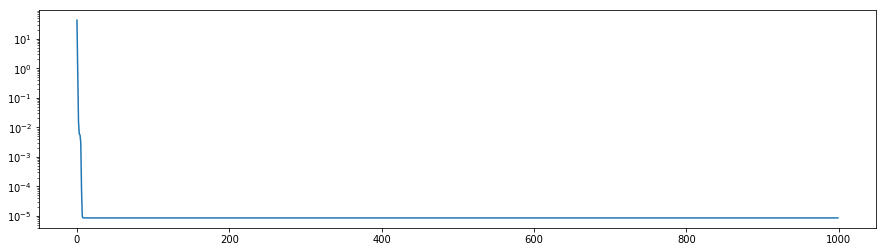

In [11]:
plt.figure(figsize=(15, 4))
plt.plot(Loss)
plt.yscale('log')
plt.show()

### Test data:

In [12]:
x_test = Variable(torch.arange(x_min, x_max, 0.001).view(-1, 1)*2, requires_grad=True)
y_pred = trial(seq, x_test)
y_real = real(x_test)

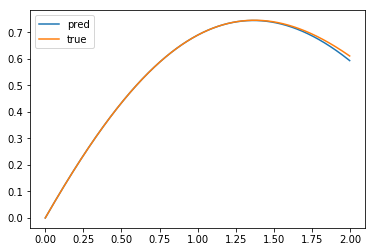

In [13]:
plt.plot(x_test.data.numpy(), y_pred.data.numpy(), label='pred')
plt.plot(x_test.data.numpy(), y_real.data.numpy(), label='true')
plt.legend(loc='best')
plt.show()

### Error:
$$error = |y_{real} - y_{predicted}|$$

In [14]:
diff = abs(y_real-y_pred)

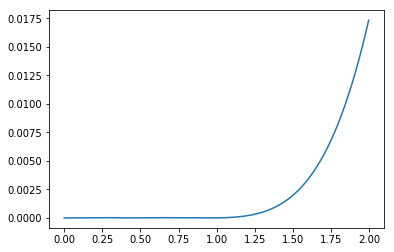

In [15]:
plt.plot(x_test.data.numpy(), diff.data.numpy())
plt.show()